In [67]:
import numpy as np
import matplotlib, pylab as plt
from scipy import optimize, interpolate, misc, integrate
import pandas as pd
import sympy as sp
from sympy import simplify, symbols, expand, factor, sin, cos, init_printing
init_printing

<function sympy.interactive.printing.init_printing>

#A).
Los siguientes datos fueron extraidos de un [perfil real de Instragram](https://www.instagram.com/paulacano24/):

https://raw.githubusercontent.com/restrepo/ComputationalMethods/master/data/Followers.json

Interprete los datos como un problema de caida libre y a partir del ajuste (fit) a la correspondiente ecuación de movimiento, determine
1. La velocidad inicial de incremento de seguidores en `followers/hour`
1. La aceleración constante en `followers/hour**2`
1. El número máximo de seguidores que alcanzaría el perfil
1. La fecha en la que se alcanzaría dicho máximo

In [43]:
#Copiamos el link y definimos el DataFrame

path = 'https://raw.githubusercontent.com/restrepo/ComputationalMethods/master/data/Followers.json'
df = pd.read_json( path )
df

,followers,date_time,hours
0,42696,2021-08-04 22:06:53.668,0.000000
1,42706,2021-08-04 23:06:56.517,1.000791
2,42716,2021-08-05 00:06:59.505,2.001621
3,42734,2021-08-05 01:07:02.174,3.002363
4,42749,2021-08-05 02:07:04.854,4.003107
...,...,...,...
615,47452,2021-09-02 12:29:21.834,686.374491
616,47486,2021-09-02 19:59:32.801,693.877537
617,47491,2021-09-02 20:59:50.542,694.882465
618,47493,2021-09-02 21:59:59.345,695.884910


In [44]:
t = df['hours']
f = df['followers']

coef = np.polyfit( t, f, deg = 2 ) #Definimos el polinomio de ajuste. Nótese que la variable independiente es el tiempo, y la dependiente los followers
poly = np.poly1d( coef, variable = 't' ) #Creamos el polinomio de grado 2, pues "sigue" las reglas de caída libre
print(poly)

           2
-0.002438 t + 8.552 t + 4.276e+04


In [51]:
dp = poly.deriv() #Derivamos el polinomio de ajuste
dp = np.poly1d(dp, variable = 't') #creamos la derivada del polinomio con la variable t
print(dp)

 
-0.004875 t + 8.552


Nótese que el primer dato del df es $t=0$, por tanto, $t - t_0 = t$. Esto justifica el hecho de que $f(t) = \frac{a}{2}t^2 + v_0t + x_0 $. \\

Así, en este caso, la aceleración estará dada por `2*poly[2]` y la velocidad inicial estará dada por `poly[1]`

In [48]:
v0 = poly[1]
print(f'La velocidad inicial es de {v0} f/h')

La velocidad inicial es de 8.552137792664016 f/h


In [49]:
a0 = 2*poly[2]
print(f'La aceleración constante es de {a0} f/h^2')

La aceleración constante es de -0.0048752543859773 f/h^2


In [56]:
tmax = dp.roots[0] #El tiempo en el que se alcanza el máximo de seguidores está dado por las raíces de la derivada.
fmax = poly(tmax)  #El número máximo de seguidores que alcanzaría está dado evaluando el polinomio en la raíz de la derivada.
fmax 

50262.136729011865

In [60]:
fecha = df['date_time'].values.astype('float')  #Se convierten los datos de fecha en el df a tipo flotante.

coef1 = np.polyfit( t, fecha, deg = 2 )   #Se define un polinomio de ajuste de la fecha en función del tiempo en horas.
poly1 = np.poly1d( coef1, variable = 't' ) #Se construye el polinomio de grado 2
print(poly1)

          2
0.003468 t + 3.6e+12 t + 1.628e+18


In [61]:
floa = poly1(tmax)  #El tiempo que el número followers alcanza el número máximo, da la fecha en la que se consigue dicha cantidad.
pd.to_datetime(floa) #Transformamos el tipo flotante a fecha.

Timestamp('2021-10-17 00:18:28.966856960')

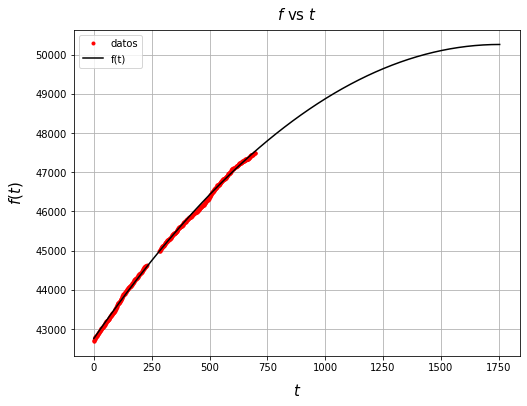

In [62]:
t_ = np.linspace( 0, tmax )

plt.figure( figsize = (8,6) )

plt.plot(t, f, 'r.', label = 'datos')
plt.plot(t_, poly(t_), 'k', label = 'f(t)')
plt.xlabel( r'$t$', size = 15, labelpad=10 )
plt.ylabel( r'$f(t)$', size = 15, labelpad=10 )
plt.legend()
plt.title( r'$f$ vs $t$', pad=10, size = 15 )

plt.grid()

#B). 
El período de  un pendulo de longitud $l$ oscilando a ángulos grandes  $\alpha$, está dado por
$$
T=T_{0} \frac{\sqrt{2}}{\pi} \int_{0}^{\alpha} \frac{d \theta}{(\cos \theta-\cos \alpha)^{\frac{1}{2}}}
$$
donde
$$
T_{0}=2 \pi \sqrt{\frac{l}{g}}
$$
es el período del mismo péndulo a pequeñas amplitudes. Culquier intento de evaluación numérico de esa integral debería fallar. Sin embargo, si hacemos el cambio de variable
$$
\sin \frac{\theta}{2}=\sin \frac{\alpha}{2} \sin \phi
$$
obtenemos
$$
T=\frac{2 T_{0}}{\pi} \int_{0}^{\frac{\pi}{2}} \frac{d \phi}{\left(1-\sin ^{2} \frac{\alpha}{2} \sin ^{2} \phi\right)^{\frac{1}{2}}}
$$
que corresponde a una integral bien comportada. 
1. Escriba un programa que use la anterio integral para calcular el cociente  $T/T_0$ para ángulos enteros (en grados) $0^\circ \le\alpha \le 90^\circ$.  
1. Genere un DataFrame de pandas que contenga como columnas: la amplitud en grados, la amplitud en radianes, y el cociente $T/T_0$, 
1. Haga un gráfico de $T/T_0$ como función de $\alpha$ (en grados). 
1. Explain the result when $\alpha = 0.$ 

In [64]:
#Definimos la función que se va a integrar

def f( ϕ, α ):
  Term_1 = np.sin(0.5*α)
  Term_2 = np.sin(ϕ)
  Term = ( 1 - (Term_1*Term_2)**2 )**0.5
  func = 1 / Term
  return func

In [65]:
α = np.arange( 0, 91, 1 ) #Alpha en grados
α_1 = np.deg2rad(α) #Alpha en radianes

In [11]:
a, b = 0, np.pi/2 #Definimos los límites de integración

In [68]:
integrate = np.vectorize(integrate.quad) #Vectorizamos la función

In [69]:
integral = integrate(f,a,b, args=(α_1)) #Calculamos la integral con el método de cuadratura

In [70]:
integral[0]

array([1.57079633, 1.57082623, 1.57091596, 1.57106552, 1.57127495,
       1.5715443 , 1.57187361, 1.57226296, 1.57271243, 1.57322212,
       1.57379213, 1.57442258, 1.57511361, 1.57586535, 1.57667798,
       1.57755166, 1.57848658, 1.57948293, 1.58054093, 1.58166081,
       1.5828428 , 1.58408717, 1.58539416, 1.58676408, 1.58819721,
       1.58969387, 1.59125438, 1.59287909, 1.59456834, 1.59632252,
       1.598142  , 1.6000272 , 1.60197853, 1.60399643, 1.60608135,
       1.60823376, 1.61045415, 1.61274303, 1.61510092, 1.61752835,
       1.6200259 , 1.62259414, 1.62523367, 1.62794511, 1.6307291 ,
       1.63358631, 1.63651741, 1.63952311, 1.64260414, 1.64576125,
       1.64899522, 1.65230683, 1.65569693, 1.65916634, 1.66271596,
       1.66634668, 1.67005943, 1.67385517, 1.67773488, 1.6816996 ,
       1.68575035, 1.68988824, 1.69411436, 1.69842986, 1.70283594,
       1.7073338 , 1.7119247 , 1.71660993, 1.72139083, 1.72626877,
       1.73124518, 1.73632149, 1.74149923, 1.74677995, 1.75216

In [71]:
T_T0 = (2/np.pi)*integral[0] #Calculamos la T / T_0

In [73]:
T_T0

array([1.        , 1.00001904, 1.00007616, 1.00017137, 1.0003047 ,
       1.00047617, 1.00068582, 1.00093369, 1.00121983, 1.00154431,
       1.00190719, 1.00230855, 1.00274847, 1.00322704, 1.00374438,
       1.00430058, 1.00489577, 1.00553006, 1.00620361, 1.00691655,
       1.00766903, 1.00846121, 1.00929327, 1.01016539, 1.01107775,
       1.01203055, 1.013024  , 1.01405832, 1.01513373, 1.01625048,
       1.0174088 , 1.01860895, 1.01985121, 1.02113584, 1.02246314,
       1.02383341, 1.02524696, 1.0267041 , 1.02820518, 1.02975053,
       1.03134052, 1.03297551, 1.03465589, 1.03638204, 1.03815439,
       1.03997334, 1.04183934, 1.04375283, 1.04571428, 1.04772416,
       1.04978296, 1.0518912 , 1.0540494 , 1.0562581 , 1.05851786,
       1.06082924, 1.06319285, 1.06560929, 1.0680792 , 1.07060321,
       1.07318201, 1.07581626, 1.0785067 , 1.08125403, 1.08405903,
       1.08692245, 1.08984511, 1.09282782, 1.09587144, 1.09897683,
       1.10214491, 1.10537659, 1.10867285, 1.11203465, 1.11546

In [74]:
#Definimos el DataFrame pedido

dff = pd.DataFrame()
dff['α'] = α
dff['α_1'] = α_1
dff['T/T_0'] = T_T0
dff

,α,α_1,T/T_0
0,0,0.000000,1.000000
1,1,0.017453,1.000019
2,2,0.034907,1.000076
3,3,0.052360,1.000171
4,4,0.069813,1.000305
...,...,...,...
86,86,1.500983,1.162214
87,87,1.518436,1.166617
88,88,1.535890,1.171105
89,89,1.553343,1.175679


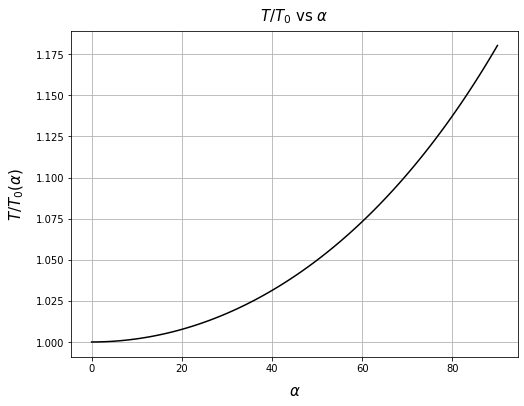

In [77]:
plt.figure( figsize = (8,6) )

plt.plot(α, T_T0, 'k')

plt.xlabel( r'$α$', size = 15, labelpad=10 )
plt.ylabel( r'$T/T_0(α)$', size = 15, labelpad=10 )
plt.title( r'$T/T_0$ vs $α$', pad=10, size = 15 )

plt.grid()

Nótese que cuando $\alpha = 0$ \\

$$T=\frac{2 T_{0}}{\pi} \int_{0}^{\frac{\pi}{2}} \frac{d \phi}{\left(1-\sin ^{2} \frac{0}{2} \sin ^{2} \phi\right)^{\frac{1}{2}}} = T=\frac{2 T_{0}}{\pi} \int_{0}^{\frac{\pi}{2}} \frac{d \phi}{\left(1-0\right)^{\frac{1}{2}}}$$ \\

$$ =\frac{2 T_{0}}{\pi} \int_{0}^{\frac{\pi}{2}}\operatorname{d}\phi = \frac{2T_0}{\pi}\frac{\pi}{2}$$ \\

Por tanto, tenemos que $T = T_0$.

Esto implica que para el ángulo de $\alpha = 0$ el período del péndulo en el modelo general está siguiendo las reglas del período en la aproximación de pequeñas oscilaciones.